# 0. Load the Libraries

In [3]:
import pandas as pd
import numpy as np
import re
import faiss
import time
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sentence_transformers import CrossEncoder

# 1. Preprocessing

In [3]:
# Read dataset
df = pd.read_csv('news_dataset.csv', encoding='latin-1')
data = df[['id', 'article']]
data.head()

,id,article
0,17307,PARIS ? When the Islamic State was about to...
1,17292,Angels are everywhere in the Mu?iz family?s ap...
2,17298,Finally. The Second Avenue subway opened in Ne...
3,17311,WASHINGTON ? It?s or time for Republica...
4,17339,"For Megyn Kelly, the shift from Fox News to NB..."


In [7]:
# Check for duplicates
data[data.duplicated(subset=['article'], keep=False)]

,id,article
41,17313,The body of the Iraqi prisoner was found naked...
219,17545,"DETROIT ? Just before the holidays, on a da..."
220,17546,"DETROIT ? Just before the holidays, on a da..."
752,18185,The body of the Iraqi prisoner was found naked...
753,18186,The body of the Iraqi prisoner was found naked...
886,18337,HOUSTON ? The chants rang out loud and long...
887,18338,HOUSTON ? The chants rang out loud and long...
888,18339,Picking the pain reliever that?s best for you ...
889,18341,Picking the pain reliever that?s best for you ...


In [8]:
# Drop duplicates
data_no_dup = data.drop_duplicates(subset=['article'],keep='first').reset_index(drop=True)
data_no_dup.head()

,id,article
0,17307,PARIS ? When the Islamic State was about to...
1,17292,Angels are everywhere in the Mu?iz family?s ap...
2,17298,Finally. The Second Avenue subway opened in Ne...
3,17311,WASHINGTON ? It?s or time for Republica...
4,17339,"For Megyn Kelly, the shift from Fox News to NB..."


In [9]:
# Check length of documents
data_no_dup['len_article'] = data_no_dup['article'].apply(lambda x:len(x))
min_len = data_no_dup['len_article'].min()
max_len = data_no_dup['len_article'].max()
print(min_len, max_len)

1074 32759


In [10]:
# Check non-ASCII characters
def check_non_ascii(text: str) -> str:
    """
    Removes non-ASCII characters from the given text.

    Args:
        text (str): The input text.

    Returns:
        str: The text with non-ASCII characters removed.
    """
    text = ''.join([char for char in text if ord(char) > 128])
    return text

check_set = set()
for i in range(len(data_no_dup)):
    check = check_non_ascii(data_no_dup['article'][i])
    for char in check:
        check_set.add(char)
check_set

{'\x81', '\x90', '\x9b', '\x9c', '\x9f', 'ª', '\xad', '®', 'ÿ'}

In [9]:
# Create function to clean data
def clean_text(text):
    """
    Cleans the given text by removing non-ASCII characters, multiple spaces, and question mark problems.

    Args:
        text (str): The text to be cleaned.

    Returns:
        str: The cleaned text.
    """
    # Remove non-ASCII characters
    text = ''.join([char for char in text if ord(char) < 128])

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Remove question mark problems
    text = re.sub(r'(\s\?)',' ',text)
    text = re.sub(r"\b\?\b", "\'", text)
    text = re.sub(r"(,\?)",",", text)
    text = re.sub(r"\?+", "?", text)
    text = text.strip()

    return text

In [17]:
# Create chunking function
def chunk_text(data_index, data_text, chunk_size, chunk_overlap):
    """
    Chunk the given text data into smaller segments.

    Parameters:
    - data_index (list): List of indices for each data entry.
    - data_text (list): List of text data entries.
    - chunk_size (int): Size of each chunk in number of words.
    - chunk_overlap (int): Number of overlapping words between chunks.

    Returns:
    - pandas.DataFrame: DataFrame containing the chunked text data with columns 'id' and 'article'.
    """

    list_chunk_text = []

    for position in range(len(data_index)):
        
        # Clean data
        words = clean_text(data_text[position]).split()

        # Chunk data
        start = 0
        part = 1
        while start < len(words):
            end = start + chunk_size
            segment = ' '.join(words[start:end])
            list_chunk_text.append((str(data_index[position]) + str(part), segment))
            part += 1
            start += (chunk_size - chunk_overlap)

    return pd.DataFrame(list_chunk_text, columns=['id', 'article'])

In [8]:
# Create dataset for evaluating generative model
data_chunk_train = chunk_text(data_no_dup[:5]['id'], data_no_dup[:5]['article'], 100, 50)
data_chunk_train.to_csv('data_chunk_train.csv', index=False)

# Create dataset for the system database
data_no_train = data_no_dup[5:].reset_index(drop=True)
data_chunk = chunk_text(data_no_train['id'], data_no_train['article'], 100, 50)
data_chunk.to_csv('data_chunk_100.csv', index=False)

In [44]:
# Set up model to encode data
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

# Vectorize data
encoded_data = model.encode(data_chunk['article'].tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))

In [45]:
# Save vector database
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(data_chunk))))
faiss.write_index(index, 'data_article_100.index')

# 2. Information Retrieval 

In [4]:
# Set up cross-encoder model
cross_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=512)

In [5]:
# Create function to fetch data
def fetch_data(doc_ids, score):
    """
    Fetches data based on the given document IDs and score.

    Parameters:
    - doc_ids (list): A list of document IDs to fetch data for.
    - score (float): The score to assign to the fetched data.

    Returns:
    - meta_dict (dict): A dictionary containing the fetched data.
        - 'id' (Series): The document IDs.
        - 'article' (Series): The articles corresponding to the document IDs.
        - 'score' (float): The assigned score.
    """
    info = data_chunk.iloc[doc_ids]
    meta_dict = {}
    meta_dict['id'] = info['id']
    meta_dict['article'] = info['article']
    meta_dict['score'] = score

    return meta_dict

In [6]:
# Create function to search top k match documents for query
def search(query, top_k, index, model):
    """
    Searches for similar documents based on a given query.

    Args:
        query (str): The query string.
        top_k (int): The number of similar documents to retrieve.
        index: The index used for searching.
        model: The model used for encoding the query.

    Returns:
        list: A list of results containing similar documents.
    """

    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)

    top_k_ids = list(top_k[1].tolist()[0])
    score = list(top_k[0].tolist()[0])

    results =  [fetch_data(idx, score) for idx, score in zip(top_k_ids, score)]

    return results

In [7]:
# Create function to retrieve top k documents with cross-encoder
def query_answer(query, query_id):
    """
    Retrieves relevant documents based on a given query and re-ranks them using a model.

    Args:
        query (str): The query string to search for.
        query_id (int): The ID of the query.

    Returns:
        list: A list of dictionaries containing the top 3 ranked results. Each dictionary contains the following keys:
            - 'question_id': The ID of the query.
            - 'question': The query string.
            - 'rank': The rank of the result.
            - 'id': The ID of the document.
            - 'article': The content of the document.
            - 'score': The score assigned to the document.

    """
    query = clean_text(query)

    # Search top 20 related documents
    results = search(query, top_k=20, index=index, model=model)

    # Re-rank the results
    model_inputs = [[query, result['article']] for result in results]
    scores = cross_model.predict(model_inputs)

    # Sort the scores in decreasing order
    ranked_results = [{'id': result['id'], 'article': result['article'], 'score': score} for result, score in zip(results, scores)]
    ranked_results = sorted(ranked_results, key=lambda x: x['score'], reverse=True)
    
    # Display top 3 results
    result_dataset = []
    for i, rank in enumerate(ranked_results[:3]):
        dataset = {'question_id': query_id,
                   'question': query,
                   'rank': i + 1,
                   'id': int(rank['id'] // 10),
                   'article': rank['article'],
                   'score': rank['score']}
        result_dataset.append(dataset)

    return result_dataset

## Testing

In [4]:
# Read vector database
index = faiss.read_index('data_article_100.index')
data_chunk = pd.read_csv('data_chunk_100.csv')
question_dataset = pd.read_csv('question_dataset.csv', encoding='latin-1')

question_dataset.drop(['Colonne1','Colonne2'], axis=1, inplace=True)
question_dataset.dropna(inplace=True)
question_dataset.rename(columns={'answer':'gold_label'}, inplace=True)
print(f'shape: {question_dataset.shape}')
display(question_dataset.head())

shape: (95, 4)


,doc_id,clean,question,gold_label
0,17340,Megyn Kelly's new office at NBC News sits a bl...,Who is NBC's chairman ?,Andrew Lack
1,17342,"In the technology industry, the sharks have ne...",Who are the Frightful Five?,"Amazon, Apple, Facebook, Microsoft, Alphabet"
2,17344,BEIJING A city official in southwest China un...,Who carried out the shooting in Panzhihua?,Chen Zhongshu
3,17346,Our new president is a billionaire Ivy League ...,Who are considered the elite?,"Corporate executives, Harvard and Yale alumni,..."
4,17284,"After the bullet shells get counted, the blood...",What is the highest murder rate precinct in Ne...,40th Precinct


In [25]:
# Create function to calculate MRR
def mrr_score(answer_data, question_data):
    """
    Calculates the Mean Reciprocal Rank (MRR) score for a given set of answer data and question data.

    Parameters:
    answer_data (list): A list of lists containing the answer data for each question.
    question_data (list): A list of integers representing the correct answer index for each question.

    Returns:
    float: The MRR score, which is the average of the reciprocal ranks for each question. 
           If no correct answer is found, returns 0.

    Example:
    answer_data = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
    question_data = [1, 4, 7]
    mrr = mrr_score(answer_data, question_data)
    print(mrr)  # Output: 0.3333333333333333
    """
    score = []
    for i, answer in enumerate(answer_data):
        for j, index in enumerate(answer):
            if index == question_data[i]:
                score.append(1 / (j + 1))
                break
        if len(score) < i + 1:
            score.append(0)
    return sum(score) / len(score) if len(score) > 0 else 0

In [27]:
# Get re-rank id lists for each question
answer_100_dataset = dict()
for idx, question in enumerate(question_dataset['question']):
    answers = query_answer(question, idx)
    for answer in answers:
        if answer['question_id'] not in answer_100_dataset:
            answer_100_dataset[answer['question_id']] = [answer['id']]
        else:
            answer_100_dataset[answer['question_id']].append(answer['id'])

article_100_ids = [answer_100_dataset[x] for x in answer_100_dataset]

# Calculate MRR score
score = mrr_score(article_100_ids, question_dataset['doc_id'])
print('MRR score:', score)

0.8243243243243243

## Test with chunking 500-word dataset

In [ ]:
# Chunk 500-word dataset
data_chunk = chunk_text(data_no_train['id'], data_no_train['article'], 500, 50)
data_chunk.to_csv('data_chunk_500.csv', index=False)

In [ ]:
# Save vector database
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(data_chunk))))
faiss.write_index(index, 'data_article_500.index')

In [ ]:
# Get re-rank id lists for each question
answer_500_dataset = dict()
for idx, question in enumerate(question_dataset['question']):
    answers = query_answer(question, idx)
    for answer in answers:
        if answer['question_id'] not in answer_500_dataset:
            answer_500_dataset[answer['question_id']] = [answer['id']]
        else:
            answer_500_dataset[answer['question_id']].append(answer['id'])

article_500_ids = [answer_500_dataset[x] for x in answer_500_dataset]

# Calculate MRR score
score = mrr_score(article_500_ids, question_dataset['doc_id'])
print('MRR score:', score)

## Test cross-encoder models

In [ ]:
# List of cross-encoder models is used to test
cross_models = ['cross-encoder/ms-marco-MiniLM-L-12-v2',
                'cross-encoder/ms-marco-MiniLM-L-6-v2',
                'cross-encoder/ms-marco-MiniLM-L-4-v2',
                'cross-encoder/ms-marco-MiniLM-L-2-v2',
                'cross-encoder/ms-marco-TinyBERT-L-6',
                'cross-encoder/ms-marco-TinyBERT-L-2-v2']

In [ ]:
# Create a function to test cross-encoder models
def test_model(question_dataset, cross_model):
    """
    Test the model by evaluating its performance on a given question dataset.

    Args:
        question_dataset (dict): A dictionary containing the question dataset.
            It should have the following keys:
            - 'question': A list of questions.
            - 'doc_id': A list of document IDs corresponding to the questions.

        cross_model: The cross model to be tested.

    Returns:
        dict: A dictionary containing the evaluation results.
            It has the following keys:
            - 'mrr_score': The Mean Reciprocal Rank (MRR) score.
            - 'time': The elapsed time in seconds.

    """
    start_time = time.time()

    # Get re-rank id lists for each question
    answer_dataset = dict()
    for idx, question in enumerate(question_dataset['question']):
        answers = query_answer(question, idx)
        for answer in answers:
            if answer['question_id'] not in answer_dataset:
                answer_dataset[answer['question_id']] = [answer['id']]
            else:
                answer_dataset[answer['question_id']].append(answer['id'])

    article_ids = [answer_dataset[x] for x in answer_dataset]
    
    # Calculate MRR score
    mrr_score = mrr_score(article_ids, question_dataset['doc_id'])
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    result = {'mrr_score': article_ids,
              'time': elapsed_time}

    return result

In [ ]:
# Test each cross-encoder model
test_result = []
for cross_model_name in cross_models:
    # Set cross-encoder model
    cross_model = CrossEncoder(cross_model_name) 

    # Test cross-encoder model
    result = test_model(question_dataset, cross_model)
    result['cross_model'] = cross_model_name    
    test_result.append(result)

In [ ]:
# Create the figure and axes
fig, ax1 = plt.subplots()
x = range(len(cross_models))

# Create bar charts for MRR score and time
ax1.bar(x, test_result['mrr_score'], width=0.35, label='MRR score', color='b')
ax1.set_ylabel('MRR score', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.bar([i + 0.35 for i in x], test_result['time'], width=0.35, label='Time', color='r')
ax2.set_ylabel('Time', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add title and labels
plt.title('Cross-encoder models performance comparison')
plt.xlabel('Cross-encoder models')
plt.xticks([i + 0.35/2 for i in x], cross_models, rotation=90)  # Adjust x-axis tick positions

# Add legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()

# 3. Reader Algorithm

In this part, two model will be compared: the classic NER model and the BERT model. These two model has different approach to solve the problem. The classic NER model is based on the CRF model, while the BERT model is based on the transformer model. Later in the notebook we will explain how these two models work.

In [29]:
import spacy
from spacy import displacy
import statistics
from rouge import Rouge 

question_dataset_ner = question_dataset.copy()

## 3.1 Named Entity Recognition (NER)

These are the step-by-step process of the NER model:
1. Find the named entities in the question
2. Find which entities should be found (target entities) based on the question
3. Find the entities in the context
4. Given the target entities and the question entities, find the answer entities in the context
5. Get most common answer entities

### 3.1.1 Find the named entities in the question
From 3.1.1 until 3.1.4 we will show how to find the answer using a simple NER model.

In this example, we will use document 14 from the dataset. As can be seen, the NER model captured the word `Bambi` as an entity.

In [ ]:
# Load the pre-trained NER model
nlp = spacy.load("en_core_web_sm")

def find_ner(text: str, display=False):
    """
    Finds named entities in the given text using spaCy's NER model.

    Args:
        text (str): The input text to analyze.
        display (bool, optional): Whether to display the named entities using spaCy's displacy. 
                                  Defaults to False.

    Returns:
        tuple: A tuple containing the spaCy document object and a list of named entities.
               The named entities are represented as dictionaries with the following keys:
               - 'text': The text of the named entity.
               - 'start': The start index of the named entity in the input text.
               - 'end': The end index of the named entity in the input text.
               - 'label': The label of the named entity.

    Example:
        >>> text = "Apple Inc. is planning to open a new store in New York City."
        >>> doc, entities = find_ner(text, display=True)
        >>> print(entities)
        [{'text': 'Apple Inc.', 'start': 0, 'end': 10, 'label': 'ORG'},
         {'text': 'New York City', 'start': 43, 'end': 56, 'label': 'GPE'}]
    """
    
    doc = nlp(text)
    entities = [{'text':ent.text,'start':ent.start, 'end':ent.end, 'label':ent.label_} for ent in doc.ents]

    if display:
        displacy.render(doc, style="ent")
    return doc, entities


In [127]:
document_number = 14
q_text = question_dataset_ner['question'][document_number]
q_doc, q_ent = find_ner(q_text, display=True)
q_ent

[{'text': 'Bambi', 'start': 2, 'end': 3, 'label': 'ORG'}]

### 3.1.2 Find the target entities

The target entity was found using a simple rule-based model. Since the question is `Who` then it will search for a `PERSON` entity.

In [ ]:
def find_target_entity(text):
    """
    Determines the target entity types based on the given text.

    Args:
        text (str): The input text.

    Returns:
        list: A list of target entity types.
    """
    
    if 'who' in text.lower():
        return ['PERSON']
    elif 'when' in text.lower():
        return ['DATE', 'EVENT', 'TIME']
    elif 'where' in text.lower():
        return ['FAC', 'GPE', 'LOC']
    elif 'what' in text.lower():
        return ['MONEY', 'NORP', 'ORG', 'PERCENT', 'PRODUCT', 'QUANTITY', 'WORK_OF_ART']
    elif 'how' in text.lower():
        return ['CARDINAL', 'ORDINAL']

In [128]:
target_ent = find_target_entity(q_text)
target_ent

['PERSON']

### 3.3.3 Find the entities in the context

The entities in the context were found using the same NER model as in the question.

In [129]:
# Define the text to be analyzed
text = question_dataset['clean'][document_number]
t_doc, t_ent = find_ner(text, display=True)

### 3.1.4 Find the answer entities in the context, given the target entities and the question entities

This is the most important part of the model. The model will find the `PERSON` entity that is near the `Bambi` entity. Tthe search scope could be limited using `num_of_words` argument. This part assumen that the answer will be near the entity `Bambi`.

When there is a `PERSON` entity near the `Bambi` entity, the model will append that entity to an array.

In [106]:
def find_entity(q_ent, target_ent, t_ent, num_of_words=15):
    """
    Finds entities in the text that are similar to the question entities and returns a list of output entities.

    Parameters:
    - q_ent (list): A list of question entities.
    - target_ent (list): A list of target entities.
    - t_ent (list): A list of text entities.
    - num_of_words (int): The maximum number of words allowed between question and target entities. Defaults to 15.

    Returns:
    - output_entities (list): A list of output entities that match the target entities.
    """
    
    idx_t_ent = []
    for qent in q_ent:
        for idx, tent in enumerate(t_ent):
            if (tent['text'].lower() in qent['text'].lower()): 
                idx_t_ent.append(idx)
        
    output_entities = []
    for target in target_ent:
        for idx in idx_t_ent:
            if idx == 0:
                if (t_ent[idx+1]['end'] - t_ent[idx]['start'] <= num_of_words) and (t_ent[idx+1]['label'] == target):
                    output_entities.append(t_ent[idx+1])
                    
            elif idx == len(t_ent)-1:
                if (t_ent[idx]['end'] - t_ent[idx-1]['start'] <= num_of_words) and (t_ent[idx-1]['label'] == target):
                    output_entities.append(t_ent[idx-1])
                    
            else:
                if (t_ent[idx]['end'] - t_ent[idx-1]['start'] <= num_of_words) and (t_ent[idx-1]['label'] == target):
                    output_entities.append(t_ent[idx-1])
                if (t_ent[idx+1]['end'] - t_ent[idx]['start'] <= num_of_words) and (t_ent[idx+1]['label'] == target):
                    output_entities.append(t_ent[idx+1])
    return output_entities

In [134]:
answer = find_entity(q_ent, target_ent, t_ent, num_of_words=15)
answer = [ent['text'] for ent in answer]
mode_value = statistics.mode(answer)
print(f"The answer from NER model: {mode_value}")
print(f"Gold Label: {question_dataset['gold_label'][document_number]}")

The answer from NER model: Wong
Gold Label: Tyrus Wong


The answer was correct. However, this method is not perfect, this method did not understand the relationship between entities. Therefore, it could captured as many entities as possible and the most common entities will be the answer.

### 3.1.5 Get the answer for all the questions

In [21]:

answer = []

for idx, row in question_dataset_ner.iterrows():
    question = row['question']
    text = row['clean']
    
    # find NER in the question
    question_doc, question_ent = find_ner(question, display=False)
    
    # find target entities
    target_ent = find_target_entity(question)
    
    # find NER in the text
    text_doc, text_ent = find_ner(text, display=False)
    
    try:
        dummy_answer = find_entity(question_ent, target_ent, text_ent, num_of_words=10)

        if len(dummy_answer) > 0:
            dummy_answer = [ent['text'] for ent in dummy_answer]
            mode_value = statistics.mode(dummy_answer)
            answer.append(mode_value)
        else:
            answer.append(' ')
    except:
        answer.append(' ')
   
question_dataset_ner['reader_answer']=answer 

### 3.1.6 NER Evaluation

In [23]:
rouge_func = Rouge()
rouge_1_precision = []
rouge_1_recall = []
rouge_1_f1 = []

for idx, row in question_dataset_ner.iterrows():
    rouge_score = rouge_func.get_scores(row['reader_answer'], row['gold_label'])
    rouge_1_precision.append(rouge_score[0]['rouge-1']['p'])
    rouge_1_recall.append(rouge_score[0]['rouge-1']['r'])
    rouge_1_f1.append(rouge_score[0]['rouge-1']['f'])
    
question_dataset_ner['rouge_1_precision'] = rouge_1_precision
question_dataset_ner['rouge_1_recall'] = rouge_1_recall
question_dataset_ner['rouge_1_f1'] = rouge_1_f1

In [84]:
ner_eval = pd.DataFrame(question_dataset_ner[['rouge_1_precision','rouge_1_recall','rouge_1_f1']].mean(), columns=['NER']).T
ner_eval

,rouge_1_precision,rouge_1_recall,rouge_1_f1
NER,0.207895,0.178947,0.187544


## 3.2 BERT Question Answering

In this part, we will user fine-tuned BERT with SQuaD dataset to find the answer. 

In [31]:
question_dataset_bert = question_dataset.copy()

In [27]:
from transformers import pipeline

model_checkpoint = "huggingface-course/bert-finetuned-squad"
question_answerer = pipeline("question-answering", model=model_checkpoint)

/Users/robinviltoriano/anaconda3/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [28]:
snippet = []

for idx, row in question_dataset_bert.iterrows():
    
    snippet.append(question_answerer(question=row['question'], context=row['clean']))
    
score = []
answer = []
start_idx = []
end_idx = []
for i in snippet:
    score.append(i['score'])
    answer.append(i['answer'])
    start_idx.append(i['start'])
    end_idx.append(i['end'])

In [32]:
question_dataset_bert['snippet'] = snippet
question_dataset_bert['score'] = score
question_dataset_bert['answer'] = answer
question_dataset_bert['start_idx'] = start_idx
question_dataset_bert['end_idx'] = end_idx

### 3.2.1 BERT Evaluation

In [33]:
def clean_text_bert(text):
    """
    Cleans the given text by converting it to lowercase, removing punctuation, and extra whitespaces.
    
    Args:
        text (str): The text to be cleaned.
        
    Returns:
        str: The cleaned text.
    """
    cleaned_text = str(text)
    cleaned_text = cleaned_text.lower()
    cleaned_text = re.sub(r'[^\w\s]', ' ', cleaned_text)
    cleaned_text = re.sub(r'\s+',' ', cleaned_text)
    return cleaned_text.strip()

In [35]:
question_dataset_bert['answer_cleaned'] = question_dataset_bert.answer.apply(lambda x: clean_text_bert(x))
question_dataset_bert['gold_label_cleaned'] = question_dataset_bert.gold_label.apply(lambda x: clean_text_bert(x))

In [36]:
rouge_func = Rouge()
rouge_1_precision = []
rouge_1_recall = []
rouge_1_f1 = []

for idx, row in question_dataset_bert.iterrows():
    rouge_score = rouge_func.get_scores(row['answer_cleaned'], row['gold_label_cleaned'])
    rouge_1_precision.append(rouge_score[0]['rouge-1']['p'])
    rouge_1_recall.append(rouge_score[0]['rouge-1']['r'])
    rouge_1_f1.append(rouge_score[0]['rouge-1']['f'])
    
question_dataset_bert['rouge_1_precision'] = rouge_1_precision
question_dataset_bert['rouge_1_recall'] = rouge_1_recall
question_dataset_bert['rouge_1_f1'] = rouge_1_f1

In [83]:
bert_eval = pd.DataFrame(question_dataset_bert[['rouge_1_precision','rouge_1_recall','rouge_1_f1']].mean(),columns=['BERT']).T
bert_eval

,rouge_1_precision,rouge_1_recall,rouge_1_f1
BERT,0.784561,0.80589,0.778616


## 3.3 Model Comparison

In [85]:
reader_eval = pd.concat([ner_eval, bert_eval], axis=0)
reader_eval

,rouge_1_precision,rouge_1_recall,rouge_1_f1
NER,0.207895,0.178947,0.187544
BERT,0.784561,0.805890,0.778616


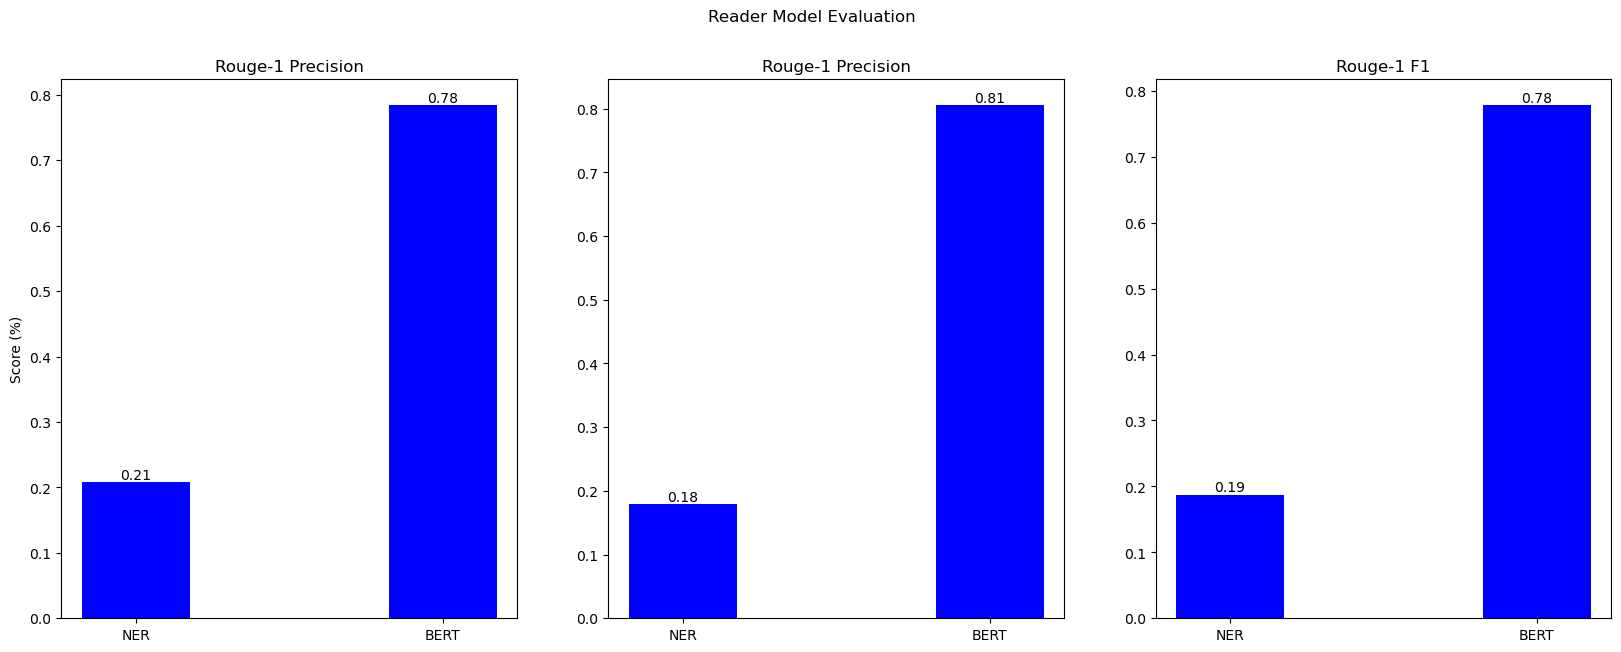

In [92]:
# Create the figure and axes
fig, ax = plt.subplots(1,3, figsize=(20,7))
# x = range(len(reader_eval))
x = reader_eval.index

# Create bar charts for MRR score and time
ax[0].bar(x, reader_eval['rouge_1_precision'], width=0.35, label='Rouge-1 Precision', color='b')
ax[0].set_ylabel('Score (%)')
ax[0].set_title('Rouge-1 Precision')
# Add the values above the bars
for i, v in enumerate(reader_eval['rouge_1_precision']):
    ax[0].text(i, v, str(round(v,2)), ha='center', va='bottom')

ax[1].bar(x, reader_eval['rouge_1_recall'], width=0.35, label='Rouge-1 Recall', color='b')
ax[1].set_title('Rouge-1 Precision')
for i, v in enumerate(reader_eval['rouge_1_recall']):
    ax[1].text(i, v, str(round(v,2)), ha='center', va='bottom')

ax[2].bar(x, reader_eval['rouge_1_f1'], width=0.35, label='Rouge-1 Recall', color='b')
ax[2].set_title('Rouge-1 F1')
for i, v in enumerate(reader_eval['rouge_1_f1']):
    ax[2].text(i, v, str(round(v,2)), ha='center', va='bottom')
    
# Add title and labels
fig.suptitle("Reader Model Evaluation")


plt.show()

# 4. Generative Model

At this part we have done choosing generative models between *google/flan-t5-base*, *James449/nlp-t5-qa-model*(finetuned based on google/flan-t5-base) and *gpt-3.5-turbo*. 

Step-by-step:
1. Create gen_test dataset with 3 columns: contexts, questions, answers
2. Using 3 different models to generate predicted answers
3. Calculate cosine similarity between answers(Ground true) and predicted answers, if the that score >= 0.5, we assume it as True
4. Evaluate accuracy, precision, recall, f1-score => Conclude which model to be used

In [ ]:
from langchain_community.llms.huggingface_hub import HuggingFaceHub
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from typing import Callable
import pandas as pd
from question import get_answer, top_k_article
from langchain_core.messages import HumanMessage
from langchain_core.retrievers import BaseRetriever
from langchain_core.callbacks import CallbackManagerForRetrieverRun
from conversation import get_conversation_chain
from sentence_transformers import SentenceTransformer
from utils import cosine_similarity

In [ ]:
def get_conversation_chain(retriever: Callable, model_name: str = "gpt-3.5-turbo") -> RunnableLambda:
    """
    Params:
    * retriever: a function that given a query, return a string of context
    * model: the model to use for the conversation (default: gpt-3.5-turbo)
    Returns:
    * conversation_chain: a chained conversation that can be invoked to get the answer to a question
    """
    model = None
    if model_name == "gpt-3.5-turbo":
        model = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
    elif model_name == "flan-t5-base":
        model = HuggingFaceHub(repo_id="google/flan-t5-base", model_kwargs={"temperature":0.5, "max_length":1000})
    elif model_name == "James449/nlp-t5-qa-model":
        model = HuggingFaceHub(repo_id="James449/nlp-t5-qa-model")
    
    
    # Reformulating the question based on the chat history and the latest user question for better understanding
    contextualize_q_system_prompt = """Given a chat history and the latest user question \
                                        which might reference context in the chat history, formulate a standalone question \
                                        which can be understood without the chat history. Do NOT answer the question, \
                                        just reformulate it if needed and otherwise return it as is."""
    contextualize_q_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", contextualize_q_system_prompt),
            MessagesPlaceholder(variable_name="chat_history"),
            ("human", "{question}"),
        ]
    )
    contextualize_q_chain = contextualize_q_prompt | model | StrOutputParser()
    
    # Contextualizing the question only if there is a chat history
    def contextualized_question(input: dict):
        if input.get("chat_history"):
            return contextualize_q_chain
        else:
            return input["question"]
    
    
    
    
    # Get the asnwers only based on the given context and the conversation history
    qa_system_prompt = """you are an AI assistant. I will give you the given context, and you will have to answer only base on given knowledge, using Natural Language. You can not use your own knowledge or public sources and databases. Things to remember:
                            1. The answer has to be from the given context that I give you.
                            2. You can not use your own knowledge or public sources and databases. This will help to avoid hallucination
                            3. If the answer is not in the given context, just say I don't know
                            4. You could use the given confidence score to decide how confident you are in your answer.
                            5. If the context is an empty string, just say I don't know.
                            Here is the given context:
                        {context}"""
    qa_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", qa_system_prompt),
            MessagesPlaceholder(variable_name="chat_history"),
            ("human", "{question}"),
        ]
    )

    conversation_chain = (
        RunnablePassthrough.assign(
            context=contextualized_question | retriever
        )
        | qa_prompt
        | model
    )
    
    return conversation_chain

In [ ]:
# Use the same model as the one used in embedding phase
embedding_model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

In [ ]:
df = pd.read_csv('gen_test.csv')
df

In [ ]:
# This function will extract context based on the question, which is isolated from previous parts. This will allow developing simultaneously.
def get_context(query):
    if query in df['questions'].values:
        return df[df['questions'] == query]['contexts'].values[0]

In [ ]:
class CustomRetriever(BaseRetriever):
    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun
    ):
        """
        Retrieves relevant documents based on the given query.

        Args:
            query (str): The query string.
            run_manager (CallbackManagerForRetrieverRun): The run manager for the retriever.(not using this feature)

        Returns:
            List[str]: A list of relevant documents.
        """
        return get_context(query)

retriever = CustomRetriever()

## Test flan-t5-base

In [ ]:
rag_chain = get_conversation_chain(retriever, model_name='flan-t5-base')

chat_history = []

def handle_qa(query):
    ai_msg = rag_chain.invoke({"question": query, "chat_history": chat_history})
    if len(chat_history) >= 10:
        chat_history.pop(0)
        chat_history.pop(0)
    chat_history.extend([HumanMessage(content=query), ai_msg])
    return chat_history

preds = []
cosin_s_scores = []
for i, row in df.iterrows():
    answer = handle_qa(row[2])
    preds.append(answer[-1])
    
    cosin_s_score = cosine_similarity(answer[-1], row[3], embedding_model)
    cosin_s_scores.append(cosin_s_score[0])
    
df['preds'] = preds
df['cosin_s_scores'] = cosin_s_scores
df

In [ ]:
false_df = df[df['cosin_s_scores'] < 0.5]
true_df = df[df['cosin_s_scores'] >= 0.5]

TP = len(true_df[true_df['answers'] != "I don't know"])
TN = len(true_df[true_df['answers'] == "I don't know"])
FP = len(false_df[false_df['answers'] != "I don't know"])
FN = len(false_df[false_df['answers'] == "I don't know"])

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
print('=====FLAN T5 Base=====')
print("Accuracy: ", round(accuracy, 2))
print("Precision: ", round(precision, 2))
print("Recall: ", round(recall, 2))
print("F1 Score: ", round(f1_score, 2))

## Test flan-t5-base finetuned. 

We finetuned flan-t5-base one finetune_gen_model.ipynb file. Please check it out for more detail.

In [ ]:
rag_chain = get_conversation_chain(retriever, model_name='James449/nlp-t5-qa-model')

chat_history = []

def handle_qa(query):
    ai_msg = rag_chain.invoke({"question": query, "chat_history": chat_history})
    if len(chat_history) >= 10:
        chat_history.pop(0)
        chat_history.pop(0)
    chat_history.extend([HumanMessage(content=query), ai_msg])
    return chat_history

preds = []
cosin_s_scores = []
for i, row in df.iterrows():
    answer = handle_qa(row[2])
    preds.append(answer[-1])
    
    cosin_s_score = cosine_similarity(answer[-1], row[3], embedding_model)
    cosin_s_scores.append(cosin_s_score[0])
    
df['preds'] = preds
df['cosin_s_scores'] = cosin_s_scores
df

In [ ]:
false_df = df[df['cosin_s_scores'] < 0.5]
true_df = df[df['cosin_s_scores'] >= 0.5]

TP = len(true_df[true_df['answers'] != "I don't know"])
TN = len(true_df[true_df['answers'] == "I don't know"])
FP = len(false_df[false_df['answers'] != "I don't know"])
FN = len(false_df[false_df['answers'] == "I don't know"])

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
print('=====FLAN T5 Base finetuned=====')
print("Accuracy: ", round(accuracy, 2))
print("Precision: ", round(precision, 2))
print("Recall: ", round(recall, 2))
print("F1 Score: ", round(f1_score, 2))

In [ ]:
rag_chain = get_conversation_chain(retriever, model_name='gpt-3.5-turbo')

chat_history = []

def handle_qa(query):
    ai_msg = rag_chain.invoke({"question": query, "chat_history": chat_history})
    if len(chat_history) >= 10:
        chat_history.pop(0)
        chat_history.pop(0)
    chat_history.extend([HumanMessage(content=query), ai_msg])
    return chat_history

preds = []
cosin_s_scores = []
for i, row in df.iterrows():
    answer = handle_qa(row[2])
    preds.append(answer[-1].content)
    
    cosin_s_score = cosine_similarity(answer[-1].content, row[3], embedding_model)
    cosin_s_scores.append(cosin_s_score[0])
    
df['preds'] = preds
df['cosin_s_scores'] = cosin_s_scores
df

In [ ]:

false_df = df[df['cosin_s_scores'] < 0.5]
true_df = df[df['cosin_s_scores'] >= 0.5]

TP = len(true_df[true_df['answers'] != "I don't know"])
TN = len(true_df[true_df['answers'] == "I don't know"])
FP = len(false_df[false_df['answers'] != "I don't know"])
FN = len(false_df[false_df['answers'] == "I don't know"])

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
print('=====GPT 3.5 Turbo=====')
print("Accuracy: ", round(accuracy, 2))
print("Precision: ", round(precision, 2))
print("Recall: ", round(recall, 2))
print("F1 Score: ", round(f1_score, 2))

After comparing 3 different models, we decided to use *GPT 3.5 Turbo*